<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Copy__new_exp_(W)_of_signal_kalman_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure

sns.set(style='darkgrid')

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [5]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [6]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [7]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)  

In [9]:
df_kalman = pd.DataFrame(nlst).T

In [10]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [11]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [ ]:
final_kalman=macd_calc(df_kalman)

In [ ]:
final_kalman.tail(2)

In [14]:
features = final_kalman.columns.tolist()

In [15]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [16]:
final_dataframe=final_kalman[feats_set1]

In [17]:
solution=np.sign(final_dataframe)

In [18]:
solution['final']=solution.sum(axis=1)

In [ ]:
solution.tail(2)

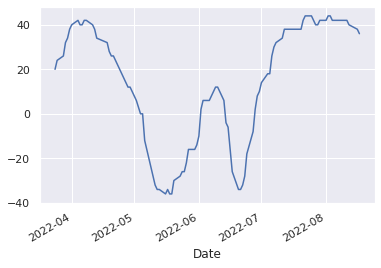

In [20]:
solution.final[-100:].plot();

In [21]:
solution['avg_mov_1']=solution['final'].rolling(window=10).mean()

nifty['avg_mov']=nifty['Adj Close'].rolling(window=22).mean()

In [22]:
l=1300

In [23]:
nifty['spread']=nifty['Close']-nifty['avg_mov']

In [24]:
nifty.head(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,spread
Date,,,,,,,,
2013-01-02,5982.600098,6006.049805,5982.000000,5993.25,5993.25,0,NaN,NaN
2013-01-03,6015.799805,6017.000000,5986.549805,6009.50,6009.50,0,NaN,NaN


In [25]:
nifty=nifty[-l:]
solution=solution[-l:]

In [26]:
nifty.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'avg_mov',
       'spread'],
      dtype='object')

In [27]:
df=pd.concat([nifty ,solution[['final','avg_mov_1']]],axis=1)


In [28]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'avg_mov',
       'spread', 'final', 'avg_mov_1'],
      dtype='object')

In [29]:
df['Up Trend'] = np.where((df['Close']>df['avg_mov']) & (df['final']>df['avg_mov_1']),1,0)

In [30]:
df['Down Trend'] = np.where((df['Close']<df['avg_mov']) & (df['final']<df['avg_mov_1']),-1,0)

In [31]:
df['signal_final']=df['Up Trend']+df['Down Trend']

In [32]:
df.signal_final.value_counts()

 1    495
 0    482
-1    327
Name: signal_final, dtype: int64

In [33]:
df=df[-300:]

In [34]:
df=df.reset_index()

In [35]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'avg_mov', 'spread', 'final', 'avg_mov_1', 'Up Trend', 'Down Trend',
       'signal_final'],
      dtype='object')

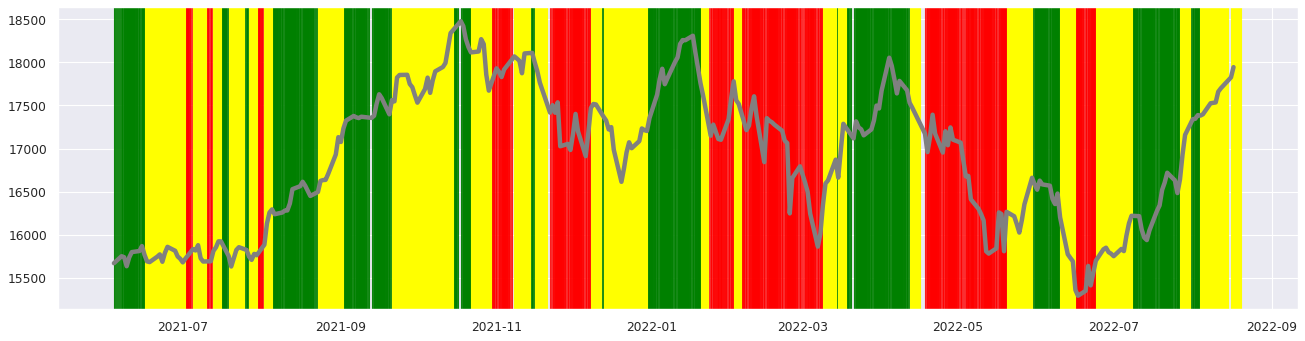

In [36]:
import datetime
df["Regime"] = df['signal_final']
figure(figsize=(20,5), dpi=80)

#plot command, save object in variable
plt.plot(df["Date"], (df.Close.values),color='grey',linewidth=4)
#plt.plot(df.close)
#filter out recession dates
recessions = df.loc[df["Regime"] == -1, 'Date']
nonrecession = df.loc[df['Regime']==1,'Date']
neodata= df.loc[df['Regime']==0,'Date']
#plot axvspan for every recession day
for day in recessions:
    
    plt.axvspan(day, day + datetime.timedelta(days=3), color="red", alpha=0.8)
for day in nonrecession:
    plt.axvspan(day, day + datetime.timedelta(days=3), color="green", alpha=0.9)
for day in neodata:
    plt.axvspan(day, day + datetime.timedelta(days=3), color="yellow", alpha=1)      
plt.show()

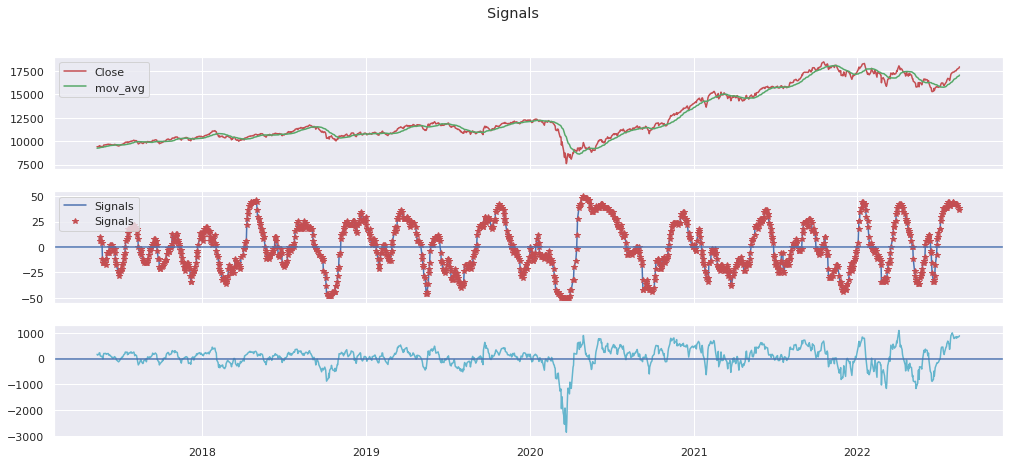

In [37]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'avg_mov'],'g', label='mov_avg')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
ax[2].plot(nifty.loc[:, :].index,nifty.loc[:,'spread'],'c',label='Spread')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
ax[2].axhline(y=0)
plt.show()

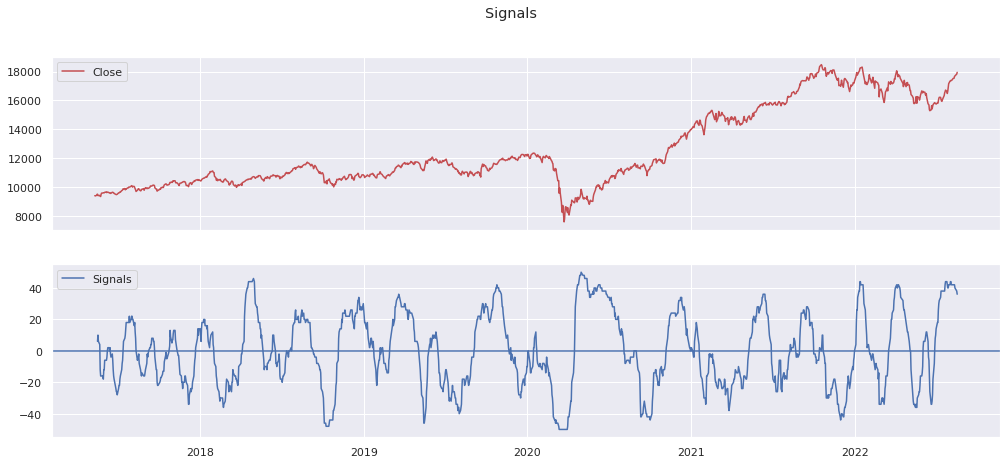

In [38]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
#ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'avg_mov'], label='Moving_Average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [39]:
new=pd.DataFrame()

In [40]:
new['signal_high'] = np.where((nifty['Close']>nifty['avg_mov']) & (solution['final']>solution['avg_mov_1']),1,0)

In [41]:
new['signal_low'] = np.where((nifty['Close']<nifty['avg_mov']) & (solution['final']<solution['avg_mov_1']),-1,0)

In [42]:
new['signal_final']=new['signal_high']+new['signal_low']

In [43]:
#pd.concat([solution.reset_index(),new[-4:]],axis=0)

In [44]:
l=1400

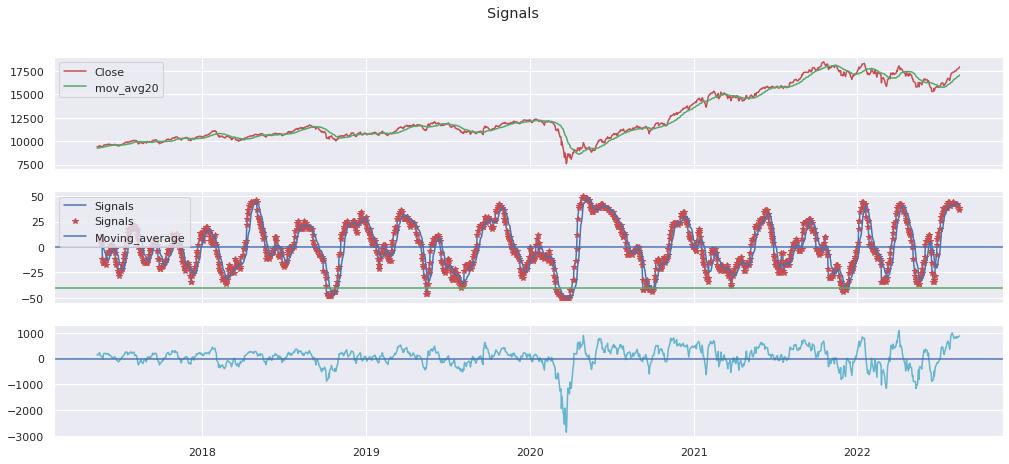

In [45]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='mov_avg20')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov_1'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')
#ax[3].plot(new.loc[:,:].index[-l:],new.loc[:,'signal_final'][-l:])
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

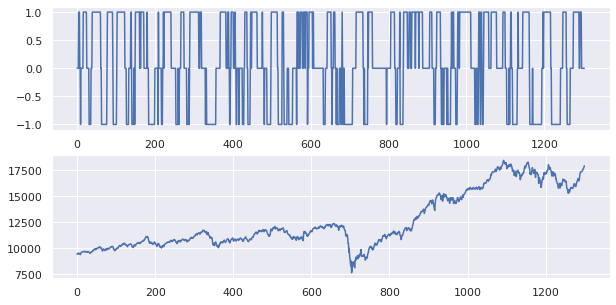

In [46]:
fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=False)
ax[0].plot(new['signal_final'][-l:])
ax[1].plot(nifty['Close'][-l:].values)
plt.show()

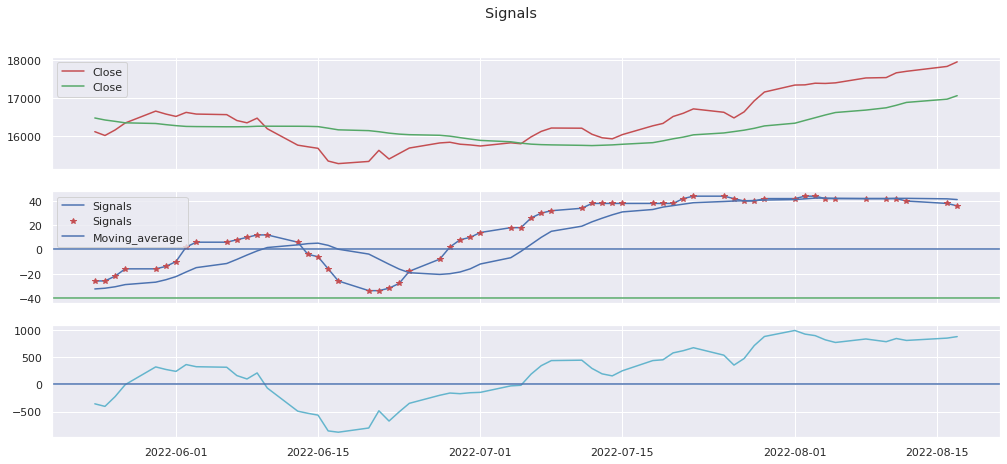

In [47]:
l=60
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='Close')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov_1'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')

plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

In [48]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [49]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal unchanged (1:stay long , -1: stay short) : 1


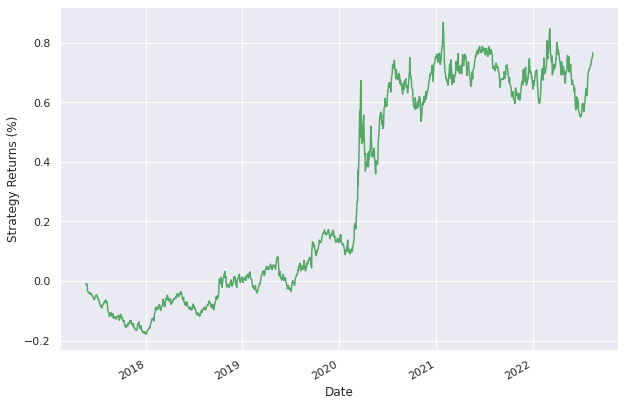

sharpe ratio :  0.044389618164703146
sortino ratio :  0.33526348520237415


In [50]:
# Calculate daily returns
nifty['Return'] = nifty.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * solution.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)

std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05)/std_neg
print('sortino ratio : ' , sortino_ratio)

In [51]:
def max_drawdown(return_series):
    comp_ret =return_series
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()
geometric_returns=pd.DataFrame(geometric_returns)

max_drawdowns= geometric_returns.apply(max_drawdown)
print('max_drawdown : ' , max_drawdowns)

max_drawdown :  Strategy_F   -2.653146
dtype: float64


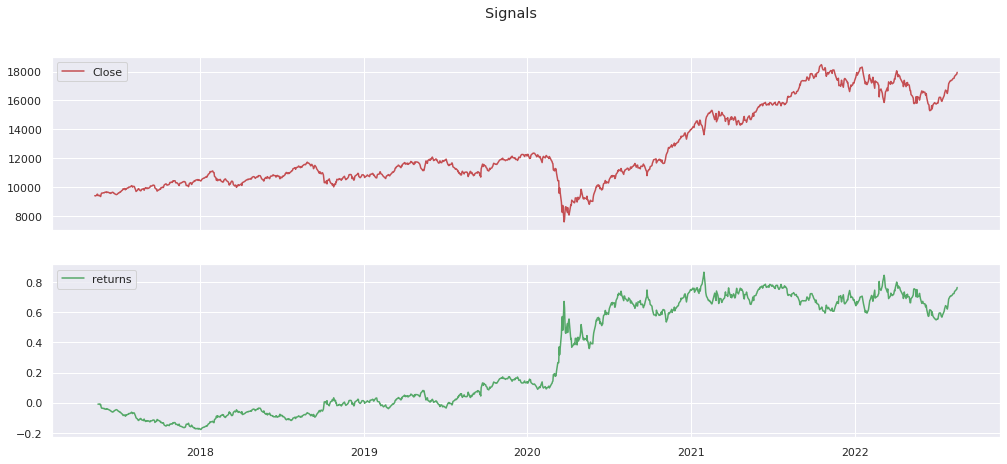

In [52]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(geometric_returns.index,geometric_returns,'g', label='returns')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
plt.show()

In [53]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,spread,Return,Strategy_F
Date,,,,,,,,,,
2022-08-16,17797.199219,17839.099609,17764.050781,17825.25,17825.25,0,16972.379528,852.870472,0.007182,0.007182
2022-08-17,17868.150391,17965.949219,17833.349609,17944.25,17944.25,0,17063.543146,880.706854,0.006676,0.006676


In [54]:
print('change in nifty from yesterday' ,(nifty.Close.iloc[-1]-nifty.Close.iloc[-2])/nifty.Close.iloc[-2]*100)

change in nifty from yesterday 0.6675923198833116
